<a href="https://colab.research.google.com/github/jake-herman/ML4E_project/blob/main/ML4E_FinalProject_basicRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RNN's to predict physical models

The data is stored as an $(n,d,1)$ matrix where each of the $n$ rows is a vector of data points of length $d$ containing the height of the ball at each timestep. 

Initial test with various starting points ranging from 1 to 50 meters in height (thus, $n = 50$), each simulation using

*   t_step = 0.01 seconds
*   t_stop = 20 seconds
    * Thus, $d = 2001$
*   coefficient of restitution (COR) = 0.8

In [ ]:
import scipy.io
import numpy as np
matlab_data = scipy.io.loadmat('bouncyball_data_2001x50')
  # saves .mat file as dictionary
data = np.array(matlab_data['data']).T.reshape(50,2001,1)
  # saves data from file as np array
print(data[33])
print("\nShape =", data.shape)
n = data.shape[0]
d = data.shape[1]

[[34.        ]
 [33.9995095 ]
 [33.998038  ]
 ...
 [ 0.20591786]
 [ 0.16876133]
 [ 0.1306238 ]]

Shape = (50, 2001, 1)


To visualize a the data at various time series:

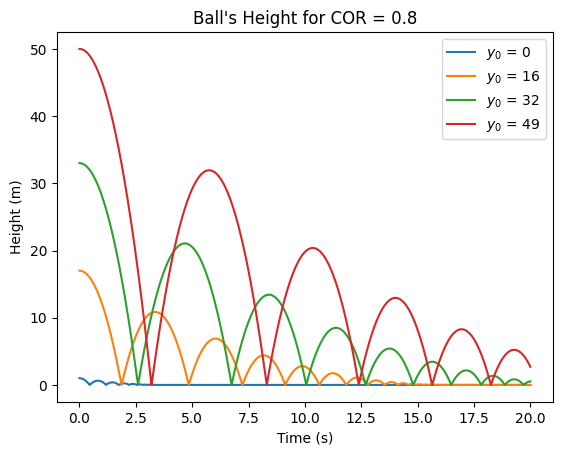

In [ ]:
import matplotlib.pyplot as plt
samples = np.linspace(0,n-1,4,dtype=int)
times = np.linspace(0,(d-1)*.01,d)
for i in samples:
    plt.plot(times,data[i,:])
plt.xlabel('Time (s)')
plt.ylabel("Height (m)")
plt.title("Ball's Height for COR = 0.8")
plt.legend(["$y_0$ = {}".format(j) for j in samples])
plt.show()

Processing the data to split it into training, validation, and testing

In [ ]:
np.random.shuffle(data)
  # shuffle data vectors
X_train,  y_train  = data[:35, :d-1] , data[:35,-1]
  # X_train - first 35 rows with all but last data point
  # y_train - last data point for each respective row
X_val,    y_val    = data[35:45, :d-1] , data[35:45,-1]
  # X_val - next 10 rows with all but last data point
  # y_val - last data point for each respective row
X_test,   y_test   = data[45:, :d-1]  , data[45:,-1] 
  # X_test - final 5 rows with all but last data point
  # y_test - last data point for each respective row

In [ ]:
X_train.shape

(35, 2000, 1)

In [ ]:
import tensorflow as tf
import keras

model = keras.models.Sequential([
        keras.layers.GRU(20, activation = "relu", return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, activation = "relu", return_sequences=False), 
        keras.layers.Dense(1) # dense layer
])
model.summary()

model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))

mse_test = model.evaluate(X_test, y_test)

print(f"MSE on test set: {mse_test:.3f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 8s 2s/step - loss: 0.9701 - val_loss: 2.3079
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.9304 - val_loss: 2.2244
Epoch 3/20
2/2 [==============================] - 5s 2s/step - loss: 0.8945 - val_loss: 2.1472
Epoch 4/20
2/2 [=================

Now that the model is trained, we can use it to predict the future of a much longer data set

In [ ]:
matlab_data = scipy.io.loadmat('predict_2001')
  # saves .mat file as dictionary
X_new = np.array(matlab_data['testdata']).reshape(1,2001,1)/np.random.randint(1,100)
  # then as an np array, scaled by a random value
steps = 10
  # number of steps forward to take

X = X_new[:,:-steps]
for step_ahead in range(steps):
        y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
          # predicts the next step
        X = np.concatenate([X, y_pred_one], axis=1)
          # and adds it to the array
Y_pred = X[:, n:]

1/1 [==============================] - 0s 173ms/step


In [ ]:
X_new.shape
#Y_pred.shape
#X.shape
for i in range(2001):
  if(X[0][i] != X_new[0][i]):
    print(i)

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


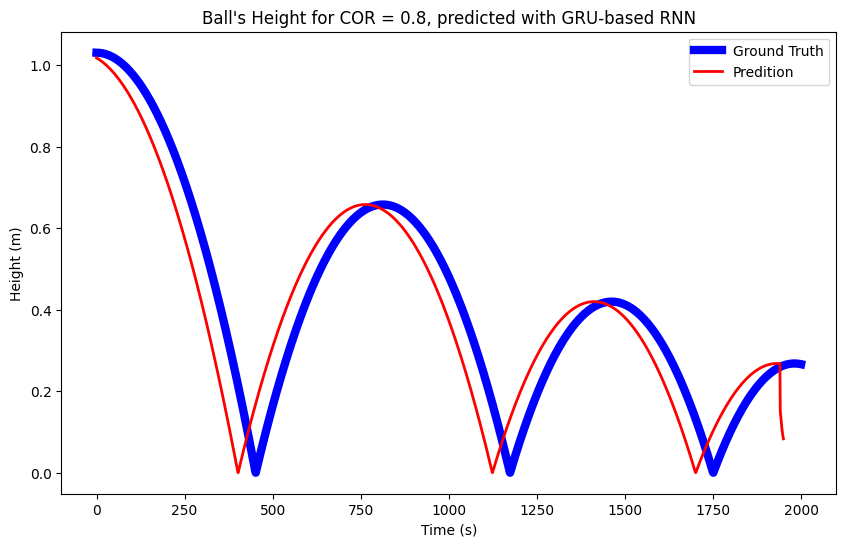

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(X_new[0],'b',lw=6)
    # plotting the ground truth
plt.plot(Y_pred[0],'r',lw=2)
    # and the predictions
plt.legend(["Ground Truth", "Predition"])
plt.xlabel('Time (s)')
plt.ylabel("Height (m)")
plt.title("Ball's Height for COR = 0.8, predicted with GRU-based RNN")
plt.show()

Herein lies the flaw of RNNs that limit them from accurately predicting physical systems:


*   Exploding/vanishing gradients prevent the RNN from storing long-term memory
*   The RNN has no way to verify physical limitations of a system
    *  e.g. the ball's position must be nonnegative, the ball's coefficient of restitution is 0.8, the ball must descend at a constant acceleration, etc.

Thus, this notebook serves as motivation to explore the $\texttt{torchdiffeq}$ package, which allows models to be represented by governing equations of a physical simulation

